# Generation: Self-RAG

> Note: This notebook is based from [langgraph_self_rag_local.ipynb](https://github.com/langchain-ai/langgraph/blob/main/examples/rag/langgraph_self_rag_local.ipynb), and has been updated to be Bedrock compatible.

![Self-RAG](../images/images-self-RAG.png)

**Self-RAG** is an advanced framework that enhances the capabilities of language models by enabling them to:

- **Adaptively retrieve** external information as needed.
- **Generate** contextually relevant responses.
- **Critique** their own outputs to ensure accuracy and quality.

This approach addresses limitations in traditional RAG systems, which may indiscriminately retrieve and incorporate a fixed number of passages, potentially leading to less relevant or unhelpful responses. 

**How Self-RAG Works:**

1. **Adaptive Retrieval:**
   - The model assesses each query to determine whether external information is necessary.
   - It can choose to retrieve multiple times during the generation process or skip retrieval entirely if the internal knowledge suffices.
2. **Generation:**
   - Utilizes both internal knowledge and any retrieved external information to produce a response that is coherent and contextually appropriate.
3. **Self-Critique:**
   - Incorporates a self-reflection mechanism where the model evaluates its own output from multiple fine-grained aspects.
   - Generates special "critique tokens" as part of the response to indicate confidence levels and potential areas of improvement.
4. **Segment-wise Beam Search:**
   - Employs a search strategy that selects the output maximizing utility based on diverse preferences, ensuring the final response aligns closely with user intent.

**Benefits of Self-RAG:**

- **Enhanced Factuality:** By retrieving information on demand and critiquing its own outputs, the model reduces the likelihood of generating incorrect or irrelevant responses.
- **Versatility:** Adapts to diverse task requirements, tailoring its behavior to provide the most appropriate responses based on the context.
- **Improved User Trust:** The self-reflection component allows the model to indicate its confidence and reasoning, fostering greater transparency and trustworthiness.

**Example in Practice:**

Imagine a user asks, "What are the latest advancements in renewable energy technologies?" The Self-RAG system would:

- **Assess the Query:**
  - Determine that external information is needed to provide an up-to-date response.
- **Retrieve Information:**
  - Fetch recent articles or papers on renewable energy advancements.
- **Generate Response:**
  - Combine internal knowledge with retrieved data to craft a comprehensive answer.
- **Self-Critique:**
  - Evaluate the response, adding critique tokens to indicate high confidence in the provided information.
- **Deliver Output:**
  - Present the user with a detailed, accurate, and current overview of advancements in renewable energy technologies.

By implementing Self-RAG, language models become more adept at handling complex queries, providing responses that are not only accurate but also contextually nuanced and self-aware.

![self-RAG](../images/self%20RAG.png)

Arxiv paper:

- [Self-RAG: Learning to Retrieve, Generate, and Critique through Self-Reflection](https://arxiv.org/abs/2310.11511)

## Setup

In [33]:
%run "../Z - Common/setup.ipynb"

!pip install -qU langgraph

We will implement some of these ideas from scratch using LangGraph.

In [34]:
import os
_set_env("TAVILY_API_KEY")

Let's index 3 blog posts.



In [35]:
from langchain_community.document_loaders import WebBaseLoader

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

doc_splits = split_sample_data(docs_list, chunk_size=250, chunk_overlap=0)
retriever = seed_sample_data(doc_splits)

Define the prompt and chain for the _Retrieval Grader_ step.

In [36]:
from langchain.prompts import PromptTemplate
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field

# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt
grade_prompt = PromptTemplate(
    template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.
    
    Retrieved document:
    
    {document}
    
    User question: {question}
    """,
    input_variables=["question", "document"],
)

retrieval_grader = grade_prompt | structured_llm_grader
question = "agent memory"

docs = retriever.invoke(question)

# print(docs)
doc_txt = docs[0].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='yes'


Define the prompt and chain for the _Generate_ step.

In [37]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = hub.pull("rlm/rag-prompt")

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

/Users/deanhart/miniconda3/envs/rag-techniques/lib/python3.11/site-packages/langsmith/client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


LLM-powered agents have two types of memory: short-term memory which involves in-context learning through prompt engineering, and long-term memory which uses external vector stores for retaining and retrieving information over extended periods. The long-term memory allows agents to store and access potentially infinite information that persists beyond individual conversations.


Define the prompt and chain for the _Hallucination Grader_ step.

In [38]:
# Data model
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )


# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

# Prompt
hallucination_prompt = PromptTemplate (
    template="""You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n 
     Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts.
    
    Set of facts:
    
    {documents}
    
    LLM generation: {generation}
    """,
    input_variables=["generation", "documents"],
)

hallucination_grader = hallucination_prompt | structured_llm_grader
hallucination_grader.invoke({"documents": docs, "generation": generation})

GradeHallucinations(binary_score='yes')

Define the prompt and chain for the _Answer Grader_ step.

In [39]:
# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )


# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeAnswer)

# Prompt
answer_prompt = PromptTemplate (
    template="""You are a grader assessing whether an answer addresses / resolves a question \n 
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question.
    
    User question: 
    
    {question}
    
   LLM generation:
    
    {generation}
    
    """,
    input_variables=["question", "generation"],
)

answer_grader = answer_prompt | structured_llm_grader
answer_grader.invoke({"question": question, "generation": generation})

GradeAnswer(binary_score='yes')

Define the prompt and chain for the _Question Rewriter_ step.

In [40]:
# Prompt
re_write_prompt = PromptTemplate (
    template="""You a question re-writer that converts an input question to a better version that is optimized \n 
     for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning.
    
    Here is the initial question:
    
    {question}
    
    Formulate an improved question.  
    """,
    input_variables=["question"],
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

'Let me help improve this question. The input "agent memory" is very brief and lacks context, but seems to be asking about how agents store or maintain information.\n\nImproved question:\n"How do AI agents maintain and store memory or state information during interactions?"\n\nThis reformulation:\n1. Expands the concept of "memory" to include state management\n2. Specifically references AI agents\n3. Uses more specific technical terminology\n4. Forms a complete, searchable question\n5. Would better match relevant documents in a vector database'

Now let's create our graph that will use Self-RAG:



In [41]:
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]

In [42]:
def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.get_relevant_documents(question)
    return {"documents": documents, "question": question}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs, "question": question}


def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}


### Edges


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"


def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

Compile the graph:

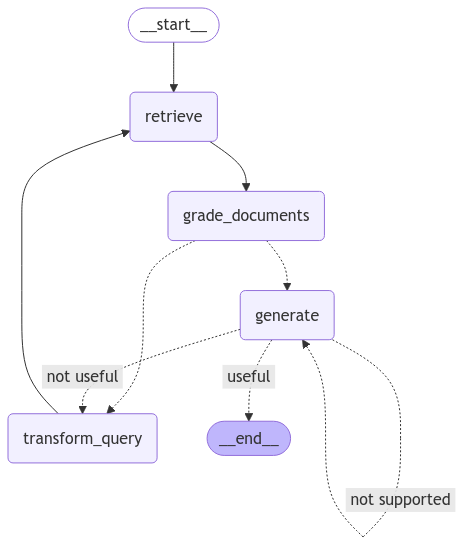

In [43]:
from langgraph.graph import END, StateGraph, START
from IPython.display import Image, display

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate", generate)
workflow.add_node("transform_query", transform_query)

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)

# Compile
app = workflow.compile()

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

Use the graph:

In [44]:
from pprint import pprint

def run_graph(question):
    inputs = {"question": question}
    for output in app.stream(inputs):
        for key, value in output.items():
            # Node
            pprint(f"Node: '{key}':")
            # Optional: print full state at each node
            # pprint(value["keys"], indent=2, width=80, depth=None)
        print("\n---\n")

    # Final generation
    pprint(value["generation"])

In [46]:
run_graph("What are the types of agent memory?")

---RETRIEVE---
"Node: 'retrieve':"

---

---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node: 'grade_documents':"

---

---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node: 'generate':"

---

('Based on the provided context, there are two main types of agent memory: '
 'short-term memory (which involves in-context learning) and long-term memory '
 '(which uses external vector stores for retaining and retrieving information '
 'over extended periods). While the context also mentions sensory memory in '
 'human brains, this appears to be separate from the agent memory types being '
 'discussed.')


In [50]:
run_graph("How does the AlphaCodium paper work?")

---RETRIEVE---
"Node: 'retrieve':"

---

---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
"Node: 'grade_documents':"

---

---TRANSFORM QUERY---
"Node: 'transform_query':"

---

---RETRIEVE---
"Node: 'retrieve':"

---

---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
"Node: 'grade_documents':"

---

---TRANSFORM QUERY---
"Node: 'transform_query':"

---

---RETRIEVE---
"Node: 'retrieve':"

---

---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
"Node: 'grade_documents':"

---

---TRANSFORM QUERY---
"Node: 'transform_query':"

---

---RETRIEVE---
"Node: 'retrieve':"

---

---CHECK DOCUMENT RE

ERROR:root:Error raised by bedrock service: An error occurred (ThrottlingException) when calling the InvokeModel operation (reached max retries: 4): Too many requests, please wait before trying again.


ThrottlingException: An error occurred (ThrottlingException) when calling the InvokeModel operation (reached max retries: 4): Too many requests, please wait before trying again.